In [1]:
import pandas as pd
import geopandas as gpd
from datetime import date

# Background

This notebook reviews a dataset of HMS smoke data collected from https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Smoke_Polygons/Shapefile/ using code/1_collect_HMS_daily_shapes.py. This dataset underwent the following alterations:
* addition of "year" and "date" columns, with values as strings to enable saving as a shapefile.
* addition of columns for days which previously did not have those columns. That is, where 2005-08-05 previously had no Density column, it now has a Density column with NA values. This is the result of concatenating all daily dataframes.

The original rows and crses for each day's shapefile can be viewed using the metadata csv.

## Load data

In [2]:
# load data
f = "../data/hms_smoke_shapes_2005_2021/hms_smoke_shapes_20050805_20211231.shp"
df = gpd.read_file(f)
df

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
0,0.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.32000 50.35000, -121.46800 50.4..."
1,1.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.67300 47.09400, -114.75200 47.0..."
2,2.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.25200 46.02700, -114.30100 46.1..."
3,3.0,1145,1715,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-78.78100 37.51000, -78.74600 37.500..."
4,4.0,1645,1945,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-123.90500 42.73000, -123.95400 42.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
439746,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.22419 19.55040, -92.41493 19.681..."
439747,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-95.21035 16.88020, -95.75144 17.073..."
439748,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-103.78492 20.64871, -103.67599 20.7..."
439749,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-102.01601 20.38415, -102.00044 20.4..."


In [3]:
def return_size_chart(df, rename="count"):
    return df.reset_index().rename(columns={0:rename})

## Preliminary Stats
How many entries per year?

In [4]:
total_grouped = df.groupby(["year"],dropna=False).size()
total_records = return_size_chart(total_grouped, "total_records")
total_records

,year,total_records
0,2005,6296
1,2006,15453
2,2007,19881
3,2008,23285
4,2009,23517
5,2010,27241
6,2011,33721
7,2012,27972
8,2013,23162
9,2014,18565


Simple chart of number of entries per year:

<AxesSubplot:xlabel='year'>

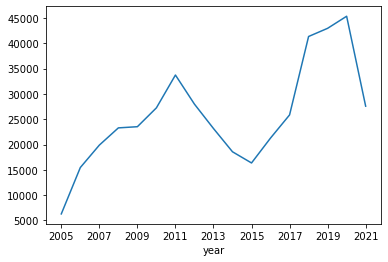

In [5]:
df.groupby(["year"],dropna=False).size().plot()

# Question 1: How complete are the density readings?

This section checks presence of non-null values by year.

**Findings:**
* 2005-2006 have no Density values
* 2007-2010 have thousands of missing Density values
* 2015 has one day with missing density values
* 2018 has one day with missing density values
* The first date for which density is recorded is April 26, 2007

Here's a table of the number of records with missing Density values per year:

In [6]:
na_densities = df.loc[df.Density.isna()].groupby(["year"],dropna=False).size()
total_records.merge(return_size_chart(na_densities, "na_density"), how="left").fillna(0).astype({'na_density': 'int32'})

,year,total_records,na_density
0,2005,6296,6296
1,2006,15453,15453
2,2007,19881,19623
3,2008,23285,5076
4,2009,23517,23369
5,2010,27241,7446
6,2011,33721,0
7,2012,27972,0
8,2013,23162,0
9,2014,18565,0


What's the first available date for which we have data?

In [7]:
df.loc[df.Density.notna()].sort_values("date").head(1)

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
26484,0.0,1245,1615,2007-04-26 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-97.53900 24.31900, -97.04000 24.591..."


The first day we have a Density value recorded is April 26, 2007.

Here is a bar graph comparing total records with records missing densities for each year:

<AxesSubplot:>

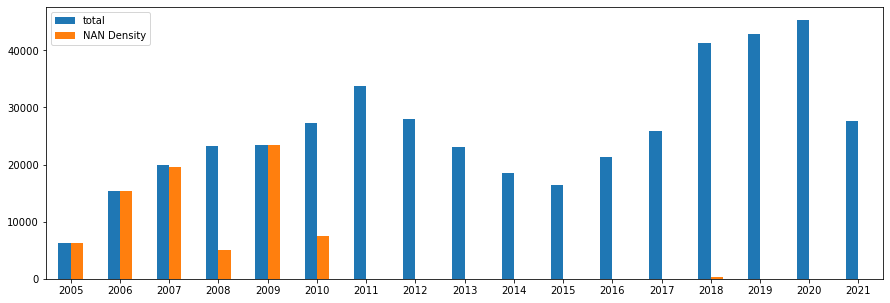

In [8]:
plotter = pd.DataFrame({'total': total_grouped.to_dict(),
                   'NAN Density': na_densities.to_dict()})
ax = plotter.plot.bar(rot=0, figsize=(15,5))

ax

There are 12 entries in 2015 and 306 entries in 2018 with null Density values. What happened there?

In [9]:
df.loc[(df.year =='2015') & df.Density.isna()]

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
219431,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
219432,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
219433,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-81.05400 26.80300, -80.99000 26.795..."
219434,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-80.78300 26.42000, -80.66700 26.406..."
219435,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-97.06800 35.66100, -97.01800 35.676..."
219436,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-99.16500 35.75300, -99.08200 35.611..."
219437,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.75400 30.54600, -86.55300 30.652..."
219438,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
219439,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
219440,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-122.78900 40.20000, -122.86600 40.2..."


In [10]:
df.loc[(df.year =='2018') & df.Density.isna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
288419,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-76.83591 20.80711, -76.83103 20.799..."
288626,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-85.95254 31.98455, -85.36831 31.574..."
288625,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.02014 32.05215, -85.98634 31.786..."
288624,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.00083 33.33651, -85.92840 33.080..."
288623,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-85.33451 33.22545, -85.22345 32.897..."
...,...,...,...,...,...,...,...,...,...,...,...,...
288518,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.57110 31.71646, -87.56622 31.711..."
288517,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
288516,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
288523,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.51983 32.17056, -87.50763 32.138..."


3/3/2018 and 1/25/2018 lack Density as well as Start/End values.

# Question 2: How many NA values exist for Start and End?

**Findings:**
* January 25, 2015 and March 3, 2018 are anomalous in their lack of Start and End dates.

In [11]:
# search for NA Start values
na_start = df.loc[(df.Start.isna())].sort_values("date")
na_start

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
219431,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
219442,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
219441,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
219439,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
219438,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
288517,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
288516,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
288515,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
288522,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


search for NA end values

In [12]:
na_end = df.loc[(df.End.isna())].sort_values("date")
na_end

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
219431,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
219442,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
219441,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
219439,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
219438,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
288517,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
288516,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
288515,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
288522,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


In [13]:
na_start.equals(na_end)

True

The output of the cell above confirms that the na_start and na_end dataframes contain the same rows.

In [14]:
df.loc[(df.End.isna())].sort_values("date").date.unique()

array(['2015-01-25 00:00:00', '2018-03-03 00:00:00'], dtype=object)

Do either dates have any non-na "Start", "End", or "Density" values?

In [15]:
df.loc[((df.date.str.contains("2015-01-25"))|(df.date.str.contains("2018-03-03"))) & ((df.End.notna())|(df.Start.notna())|(df.Density.notna()))].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry


No.

# Question 3: What missing values exist for "Satellite"? How might present values be used?

**Conclusion:** Before 2017, few "Satellite" values were recorded and data review alone does not clarify how the values present might be effectively used. In and after 2017, tagging is a regular occurrence and could be useful in deciding what data to pick.

How many rows contain satellite values?

In [16]:
df.loc[df.Satellite.notna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
85633,NaN,2009271 1330,2009271 1430,2009-09-28 00:00:00,2009,5.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-106.79600 43.59900, -103.95100 42.1..."
85707,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-115.62200 47.21000, -115.55300 47.4..."
85706,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-120.89700 46.77300, -120.97600 46.6..."
85705,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-113.71100 46.06000, -113.41000 46.4..."
85704,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-115.25900 47.16300, -114.92400 47.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...
439745,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-80.86339 26.67656, -80.87560 26.731..."
439746,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.22419 19.55040, -92.41493 19.681..."
439747,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-95.21035 16.88020, -95.75144 17.073..."
439748,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-103.78492 20.64871, -103.67599 20.7..."


What's the occurrence of different Satellite values from 2005-2016?

In [17]:
# count occurrence of density values by year
return_size_chart(df.groupby(["year", "Satellite"],dropna=False).size())

,year,Satellite,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NOAA Satellites,148
5,2009,NaN,23369
6,2010,NOAA Satellites,360
7,2010,NaN,26881
8,2011,NaN,33721
9,2012,NOAA Satellites,71


# Question 4: What about altitudeMo, tessellate, extrude, visibility?

**Conclusion:** Present only for January 25, 2015.

In [18]:
return_size_chart(df.groupby(["year", "altitudeMo"],dropna=False).size())

,year,altitudeMo,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


In [19]:
return_size_chart(df.groupby(["year", "tessellate"],dropna=False).size())

,year,tessellate,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


In [20]:
return_size_chart(df.groupby(["year", "extrude"],dropna=False).size())

,year,extrude,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


In [21]:
return_size_chart(df.groupby(["year", "visibility"],dropna=False).size())

,year,visibility,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


# Question 5: How completely do the datasets cover dates for each year?

**Findings:**
- Almost every year has days for which no smoke plumes are recorded. 

**Follow-up:**
- Investigate ways to determine when days are missing, and when the absence is indicative of no smoke plumes across the US for that day.
  - Consider looking at which dates are missing (winter months may indicate no smoke activity)
  - Examine whether the days before and after contained wildfire smoke (this would suggest the data is missing)

In [22]:
d2005 = (date(2005,12,31)-date(2005,8,5)).days
days = [d2005]
days.extend([365,365,366,365]*4)
daynums = pd.DataFrame({"year":range(2005,2022), "days": days})
df.year = df.year.astype("int32")
daynums = daynums.merge(df[["year","date"]].groupby(["year"]).nunique().reset_index()).rename(columns={"date":"present"})
daynums['missing'] = daynums['days'] - daynums['present']
daynums

,year,days,present,missing
0,2005,148,146,2
1,2006,365,356,9
2,2007,365,358,7
3,2008,366,359,7
4,2009,365,360,5
5,2010,365,362,3
6,2011,365,363,2
7,2012,366,362,4
8,2013,365,359,6
9,2014,365,357,8


In [23]:
dateseries = pd.date_range(start='8/5/2005',end='12/31/2016')

In [24]:
df["date"] = pd.to_datetime(df["date"])
df_indexed = df.drop_duplicates(subset="date").set_index("date")
df_indexed

,ID,Start,End,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
date,,,,,,,,,,,
2005-08-05,0.0,1200,1700,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.32000 50.35000, -121.46800 50.4..."
2005-08-06,0.0,1200,1730,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.47600 50.24800, -121.55700 50.2..."
2005-08-07,0.0,1200,1730,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-117.73500 46.05500, -117.70600 46.3..."
2005-08-08,0.0,1600,2130,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.47400 50.43100, -121.09600 50.4..."
2005-08-11,0.0,1345,1815,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-118.64600 36.86900, -118.69500 36.8..."
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,NaN,2021361 1100,2021361 1400,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-80.51076 27.30493, -80.54045 27.315..."
2021-12-28,NaN,2021362 1400,2021362 1600,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-105.02307 20.85387, -105.05149 20.6..."
2021-12-29,NaN,2021363 1450,2021363 1710,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.49693 19.49846, -93.06537 20.379..."


In [25]:
dateseries = pd.date_range(start='8/5/2005',end='12/31/2016')
dateseries.difference(df_indexed.index).to_list()

[Timestamp('2005-08-09 00:00:00'),
 Timestamp('2005-08-10 00:00:00'),
 Timestamp('2005-12-18 00:00:00'),
 Timestamp('2006-01-22 00:00:00'),
 Timestamp('2006-01-29 00:00:00'),
 Timestamp('2006-03-27 00:00:00'),
 Timestamp('2006-04-01 00:00:00'),
 Timestamp('2006-06-30 00:00:00'),
 Timestamp('2006-07-14 00:00:00'),
 Timestamp('2006-07-15 00:00:00'),
 Timestamp('2006-11-04 00:00:00'),
 Timestamp('2006-12-24 00:00:00'),
 Timestamp('2007-01-08 00:00:00'),
 Timestamp('2007-02-03 00:00:00'),
 Timestamp('2007-03-31 00:00:00'),
 Timestamp('2007-04-10 00:00:00'),
 Timestamp('2007-08-21 00:00:00'),
 Timestamp('2007-12-12 00:00:00'),
 Timestamp('2007-12-25 00:00:00'),
 Timestamp('2008-01-23 00:00:00'),
 Timestamp('2008-01-24 00:00:00'),
 Timestamp('2008-03-05 00:00:00'),
 Timestamp('2008-06-05 00:00:00'),
 Timestamp('2008-12-15 00:00:00'),
 Timestamp('2008-12-25 00:00:00'),
 Timestamp('2008-12-26 00:00:00'),
 Timestamp('2009-01-30 00:00:00'),
 Timestamp('2009-04-08 00:00:00'),
 Timestamp('2009-06-

# Additional Reference

Previous studies using HMS smoke data:

## Zhou et al. 2021
* Paper: "[Excess of COVID-19 cases and deaths due to fine particulate matter exposure during the 2020 wildfires in the United States](https://pubmed.ncbi.nlm.nih.gov/34389545/)" 
* Repository: [xiaodan-zhou/covid_wildfire](https://github.com/xiaodan-zhou/covid_wildfire)

HMS datasets in repository are:
* [HMS_county_2020.csv](https://github.com/xiaodan-zhou/covid_wildfire/blob/master/data/HMS_county_2020.csv) 
* [HMS_zipCodes_2020.csv](https://github.com/xiaodan-zhou/covid_wildfire/blob/master/data/HMS_zipCodes_2020.csv).

Both CSVs consist of daily readings where the only value which appears is 5,16, or 27. We can therefore conclude that the value shown is chosen from among plume shapes that intersect with the county, not computed.

In the repo code, only HMS_county_2020.csv is used. The code that produced the CSVs does not appear to be included. Here is where hms_county appears in the repo code:

in Utilities.R:
```R
## merge with hazard data 0=nosmoke, 5=(0,10)light, 16=(11-20)medium, 27=(21,32)heavy
hms = read.csv("data/HMS_county_2020.csv")
hms = tidyr::gather(data=hms, key="date", value="hazardmap", -"County", -"GEOID")
hms$date = mdy("01-01-2020") + (as.numeric(substr(hms$date, 2, 5)) - 1)
hms$hazardmap[is.na(hms$hazardmap)] = 0
hms$GEOID = as.factor(as.character(hms$GEOID))
df = merge(df, hms, by.x=c("date", "FIPS"), by.y=c("date", "GEOID"), all.x=T)
# df = df[df$date <= max(hms$date), ]
rm(hms)
```

in Combine.R:
```R
################################ get hazard data ################################ 
# 0=nosmoke, 5=(0,10)light, 16=(11-20)medium, 27=(21,32)heavy
hms = read.csv("HMS_county_2020.csv")
hms = tidyr::gather(data=hms, key="date", value="hazardmap", -"County", -"GEOID")
hms$date = mdy("01-01-2020") + (as.numeric(substr(hms$date, 2, 5)) - 1)
hms$hazardmap[is.na(hms$hazardmap)] = 0
names(hms)[names(hms) == "GEOID"] = "FIPS"
hms$FIPS = substr(100000 + hms$FIPS, 2, 6)
hms = hms[, c("FIPS", "date", "hazardmap")]
max(hms$date[hms$hazardmap == 27])
...
################################ merge all together ################################ 
...
df = left_join(df, hms, by=c("FIPS", "date"))
df = left_join(df, mobility, by=c("FIPS", "date"))
rm(cases, deaths, pop, pm, climate, hms, mobility)
```

"hazardmap" is the smoke density value. 
```R
################################ wildifre contribution to pm2.5 2020 ################################
### wildfire period scenario one 
df$wildfire = NA
df$wildfire = (df$hazardmap==27)&(!is.na(df$hazardmap))
rows1 = (df$wildfire==T)&(!is.na(df$wildfire))

df$pm_wildfire = 0
df$pm_wildfire[rows1] = pmax(df$pm25[rows1] - df$pm25_history[rows1], 0)
df$pm_ambient = df$pm25 - df$pm_wildfire

# check 
sum(rows1)
rm(rows1)
...
################################ save data ################################ 
write.csv(df, 'moddat_Feb2021.csv', row.names=F)
```